In [2]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
# データの読み込み
data_test = pd.read_csv('UNSW_NB15/UNSW_NB15_training-set.csv')
data_train = pd.read_csv('UNSW_NB15/UNSW_NB15_testing-set.csv')

# データの確認
print(f"data_train shape is : {data_train.shape}")
print(f"data_test shape is : {data_test.shape}")
print(data_train.head())
print(data_test.head())


data_train shape is : (175341, 45)
data_test shape is : (82332, 45)
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_lt

In [4]:
# データの前処理
target_train = data_train['label']
target_test = data_test['label']

# 不要な列の削除
data_train = data_train.drop(['id', "proto", "service", "state", "is_sm_ips_ports", "is_ftp_login", "attack_cat", "label"], axis=1)
data_test = data_test.drop(['id', "proto", "service", "state", "is_sm_ips_ports", "is_ftp_login", "attack_cat", "label"], axis=1)

# データの確認
print(f"data_train shape is : {data_train.shape}")
print(f"data_test shape is : {data_test.shape}")
print(data_train.head())
print(data_test.head())


data_train shape is : (175341, 37)
data_test shape is : (82332, 37)
        dur  spkts  dpkts  sbytes  dbytes       rate  sttl  dttl  \
0  0.121478      6      4     258     172  74.087490   252   254   
1  0.649902     14     38     734   42014  78.473372    62   252   
2  1.623129      8     16     364   13186  14.170161    62   252   
3  1.681642     12     12     628     770  13.677108    62   252   
4  0.449454     10      6     534     268  33.373826   254   252   

          sload          dload  ...  ct_srv_src  ct_state_ttl  ct_dst_ltm  \
0  14158.942380    8495.365234  ...           1             0           1   
1   8395.112305  503571.312500  ...          43             1           1   
2   1572.271851   60929.230470  ...           7             1           2   
3   2740.178955    3358.622070  ...           1             1           2   
4   8561.499023    3987.059814  ...          43             1           2   

   ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  ct_ft

In [5]:
# trainデータを分割してtestデータを作成する場合
from sklearn.model_selection import train_test_split

# データの分割
X_train, X_test, y_train, y_test = train_test_split(data_train, target_train, test_size=0.3, random_state=0)
data_train = X_train
target_train = y_train
data_test = X_test
target_test = y_test

# データの確認
print(f"data_train shape is : {data_train.shape}")
print(f"data_test shape is : {data_test.shape}")
print(data_train.head())
print(data_test.head())


data_train shape is : (122738, 37)
data_test shape is : (52603, 37)
             dur  spkts  dpkts  sbytes  dbytes           rate  sttl  dttl  \
41479   0.581798     10      6     588     268      25.782144   254   252   
174119  0.000009      2      0     114       0  111111.107200   254     0   
39585   0.294033      8     12     424    8824      64.618599    31    29   
23269   0.001059      2      2     146     178    2832.861107    31    29   
35227   1.433471     52     54    2934    3742      73.248780    31    29   

               sload          dload  ...  ct_srv_src  ct_state_ttl  \
41479   7.287752e+03    3080.106689  ...           1             1   
174119  5.066666e+07       0.000000  ...          31             2   
39585   1.009411e+04  220084.140600  ...           3             0   
23269   5.514636e+05  672332.375000  ...           4             0   
35227   1.606171e+04   20498.496090  ...           1             0   

        ct_dst_ltm  ct_src_dport_ltm  ct_dst_spo

accuracy_score is : 0.960154363819554


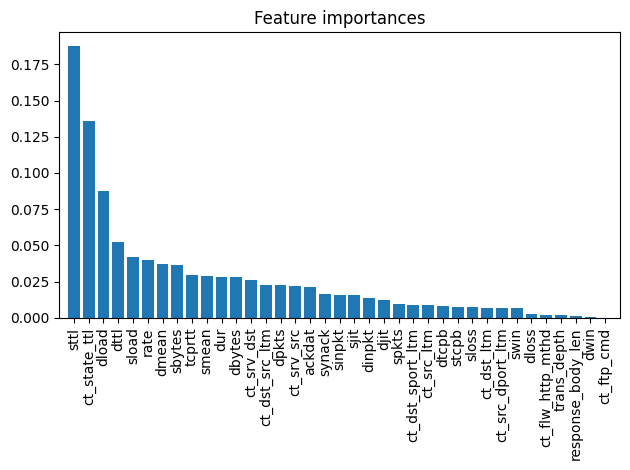

In [6]:
# random forest
from sklearn.ensemble import RandomForestClassifier

# モデルの作成
model = RandomForestClassifier(n_estimators=100, random_state=42)

# モデルの学習
model.fit(data_train, target_train)

# モデルの評価
predict = model.predict(data_test)
print(f"accuracy_score is : {accuracy_score(target_test, predict)}")

# 重要な特徴量の可視化
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(data_train.shape[1]), importances[indices], align='center')
plt.xticks(range(data_train.shape[1]), data_train.columns[indices], rotation=90)
plt.xlim([-1, data_train.shape[1]])
plt.tight_layout()
plt.show()


In [16]:
# iforestで異常検知
from sklearn.ensemble import IsolationForest

# データを正常と異常に分割
data_train_normal = data_train[target_train == 0] # 0がnormal
data_train_anomaly = data_train[target_train == 1]  # 1がanomaly

# 特徴量の選択
important_features = data_train.columns[importances > 0.03]

data_train_normal_dropped = data_train_normal[important_features]
data_train_anomaly_dropped = data_train_anomaly[important_features]
data_test_dropped = data_test[important_features]

# モデルの作成
model_normal = IsolationForest(contamination=0.01, random_state=42)
model_anomaly = IsolationForest(contamination=0.01, random_state=42)

# モデルの学習
model_normal.fit(data_train_normal_dropped)
model_anomaly.fit(data_train_anomaly_dropped)

# モデルの評価
predict_normal = model_normal.predict(data_test_dropped)
predict_normal = np.where(predict_normal == 1, 0, 1) # 1が正常になるように変換
predict_anomaly = model_anomaly.predict(data_test_dropped)
predict_anomaly = np.where(predict_anomaly == 1, 1, 0) # 1が異常になるように変換

# 結果の確認
# 結果の確認
results = {
    "data_train_normal_dropped shape": data_train_normal_dropped.shape,
    "data_train_anomaly_dropped shape": data_train_anomaly_dropped.shape,
    "data_test_dropped shape": data_test_dropped.shape,
    "accuracy_score_normal": accuracy_score(target_test, predict_normal),
    "accuracy_score_anomaly": accuracy_score(target_test, predict_anomaly),
    "predict_normal value count": pd.Series(predict_normal).value_counts().to_dict(),
    "predict_anomaly value count": pd.Series(predict_anomaly).value_counts().to_dict(),
}

for key, value in results.items():
    print(f"{key}:\n{value}\n")


data_train_normal_dropped shape:
(39308, 8)

data_train_anomaly_dropped shape:
(83430, 8)

data_test_dropped shape:
(52603, 8)

accuracy_score_normal:
0.3429652301199551

accuracy_score_anomaly:
0.8413778681824231

predict_normal value count:
{0: 50892, 1: 1711}

predict_anomaly value count:
{1: 43539, 0: 9064}



target_test value_counts is : label
1    35911
0    16692
Name: count, dtype: int64


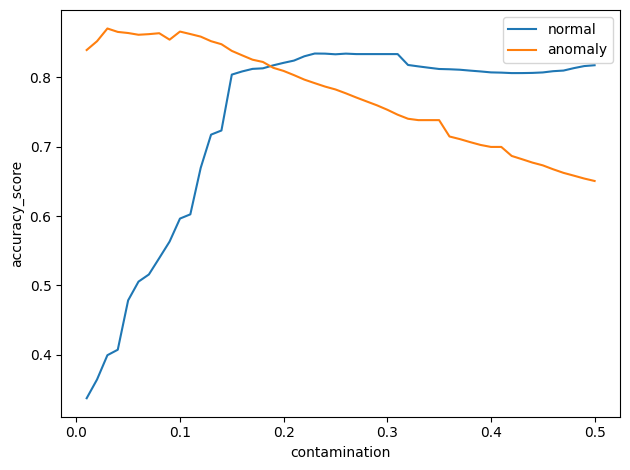

In [8]:
# テストデータの不均衡性の確認
print(f"target_test value_counts is : {target_test.value_counts()}")

# contaminationの最適化
contaminations = np.linspace(0.01, 0.5, 50)
scores_normal = []
scores_anomaly = []

for contamination in contaminations:
    model_normal = IsolationForest(contamination=contamination, random_state=0)
    model_anomaly = IsolationForest(contamination=contamination, random_state=0)
    model_normal.fit(data_train_normal_dropped)
    model_anomaly.fit(data_train_anomaly_dropped)
    predict_normal = model_normal.predict(data_test_dropped)
    predict_normal = np.where(predict_normal == 1, 0, 1)
    predict_anomaly = model_anomaly.predict(data_test_dropped)
    predict_anomaly = np.where(predict_anomaly == 1, 1, 0)
    scores_normal.append(accuracy_score(target_test, predict_normal))
    scores_anomaly.append(accuracy_score(target_test, predict_anomaly))

plt.figure()
plt.plot(contaminations, scores_normal, label='normal')
plt.plot(contaminations, scores_anomaly, label='anomaly')
plt.xlabel('contamination')
plt.ylabel('accuracy_score')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
def calculate_fpr_tpr(y_true, y_pred):
    # 真陽性、偽陽性、真陰性、偽陰性の初期化
    TP = FP = TN = FN = 0

    # 真陽性、偽陽性、真陰性、偽陰性の計算
    for i in range(len(y_true)):
        if y_true[i] == 1:  # 実際のクラスが1の場合
            if y_pred[i] == 1:
                TP += 1
            else:
                FN += 1
        else:  # 実際のクラスが0の場合
            if y_pred[i] == 1:
                FP += 1
            else:
                TN += 1

    # FPRとTPRの計算
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)

    return FPR, TPR

In [10]:
# contamination ratioに対するfpr, tpr, thresholdを計算
contaminations = np.linspace(0.01, 0.5, 50)
fprs_normal, tprs_normal, thresholds_normal = [], [], []
fprs_anomaly, tprs_anomaly, thresholds_anomaly = [], [], []
target_test_array = target_test.values

for contamination in contaminations:
    model_normal = IsolationForest(contamination=contamination, random_state=42)
    model_anomaly = IsolationForest(contamination=contamination, random_state=42)

    model_normal.fit(data_train_normal_dropped)
    model_anomaly.fit(data_train_anomaly_dropped)

    y_pred_normal = model_normal.predict(data_test_dropped).values
    y_pred_normal = np.where(y_pred_normal == -1, 1, 0)
    print(y_pred_normal.shape)
    print(target_test_array.shape)

    y_pred_anomaly = model_anomaly.predict(data_test_dropped)
    y_pred_anomaly = np.where(y_pred_anomaly == -1, 0, 1)

    # fpr, tprを計算
    FPR, TPR = calculate_fpr_tpr(target_test, y_pred_normal)
    fprs_normal.append(FPR)
    tprs_normal.append(TPR)
    thresholds_normal.append(contamination)

    FPR, TPR = calculate_fpr_tpr(target_test, y_pred_anomaly)
    fprs_anomaly.append(FPR)
    tprs_anomaly.append(TPR)
    thresholds_anomaly.append(contamination)
                
# AUCを計算
from sklearn.metrics import auc
auc_normal = auc(fprs_normal, tprs_normal)
auc_anomaly = auc(fprs_anomaly, tprs_anomaly)


plt.figure(figsize=(10, 6))
plt.title(f"ROC curve_normal AUC = {auc_normal}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fprs_normal, tprs_normal)
plt.show()

plt.figure(figsize=(10, 6))
plt.title(f"ROC curve_anomaly AUC = {auc_anomaly}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fprs_anomaly, tprs_anomaly)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'